# Import des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires (pandas, numpy, sklearn, matplotlib, shap, lime, etc.) et chargement des données des statistiques d'équipes et des résultats de matchs.

In [59]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import shap
import xgboost as xgb

train_home_team_statistics_df = pd.read_csv('./data/Train_data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./data/Train_data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv("./data/Y_train.csv", index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

train_new_y = train_scores[['HOME_WINS', 'DRAW', 'AWAY_WINS']]

X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42) # 80% train, 20% test
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42) # 80% train, 20% valid



# XGBoost naïf
Développement et évaluation de modèles inheremment interprétables comme la régression logistique, les arbres de décision et les règles de décision.

In [ ]:
# Convert multi-class labels to single-class indices
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
y_train_single = y_train.idxmax(axis=1).map(label_mapping)  # Map string labels to numerical values
y_test_single = y_test.idxmax(axis=1).map(label_mapping)

# XGBoost
model = xgb.XGBClassifier(n_estimators=1000, random_state=42)
model.fit(X_train, y_train_single)

y_pred = model.predict(X_test)

Accuracy:  1.0


## feature importance de XGB

XGBoost évalue l'importance des caractéristiques en mesurant la réduction de la perte qu'elles apportent lors des divisions dans les arbres, ainsi que leur fréquence d'utilisation et l'impact sur les observations.

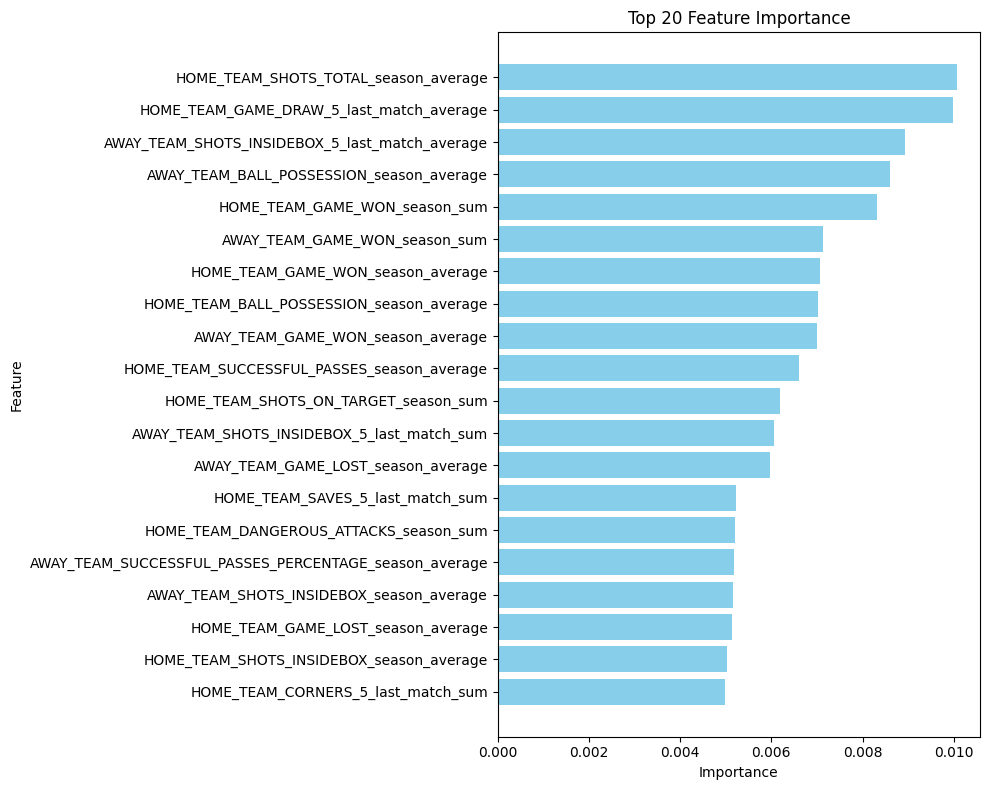

['HOME_TEAM_SHOTS_TOTAL_season_average',
 'HOME_TEAM_GAME_DRAW_5_last_match_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_average',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'HOME_TEAM_GAME_WON_season_sum',
 'AWAY_TEAM_GAME_WON_season_sum',
 'HOME_TEAM_GAME_WON_season_average',
 'HOME_TEAM_BALL_POSSESSION_season_average',
 'AWAY_TEAM_GAME_WON_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_sum',
 'AWAY_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SAVES_5_last_match_sum',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum',
 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_CORNERS_5_last_match_sum']

In [ ]:
# Obtenir l'importance des caractéristiques
importance = model.feature_importances_
features = X_train.columns

# Créer un DataFrame pour visualiser l'importance des caractéristiques
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Limiter aux 20 caractéristiques les plus importantes
top_features = importance_df.head(20)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(10, 8))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importance')
plt.gca().invert_yaxis()  # Inverser l'ordre pour afficher les plus importantes en haut
plt.tight_layout()
plt.show()

Ici plus une feature est importante plus elle réduit la "perte" du model. C'est-à-dire que plus il utilise cette valeur moins il se trompe.

Par exemple ici les caractéristiques liées aux actions offensives (tirs, possession, passes) sont très importantes. Et les caractéristiques de l'équipe à domicile semblent légèrement plus influentes que celles de l'équipe à l'extérieur, ce qui pourrait refléter un avantage du terrain qui se confirme par l'experience (les équipes a domicile gagne plus en générale).

Nous allons maintenant tenter de confirmer ces résultats avec d'autre méthode

## SHAP
SHAP est une méthode qui utilise la théorie des jeux pour expliquer les prédictions d'un modèle

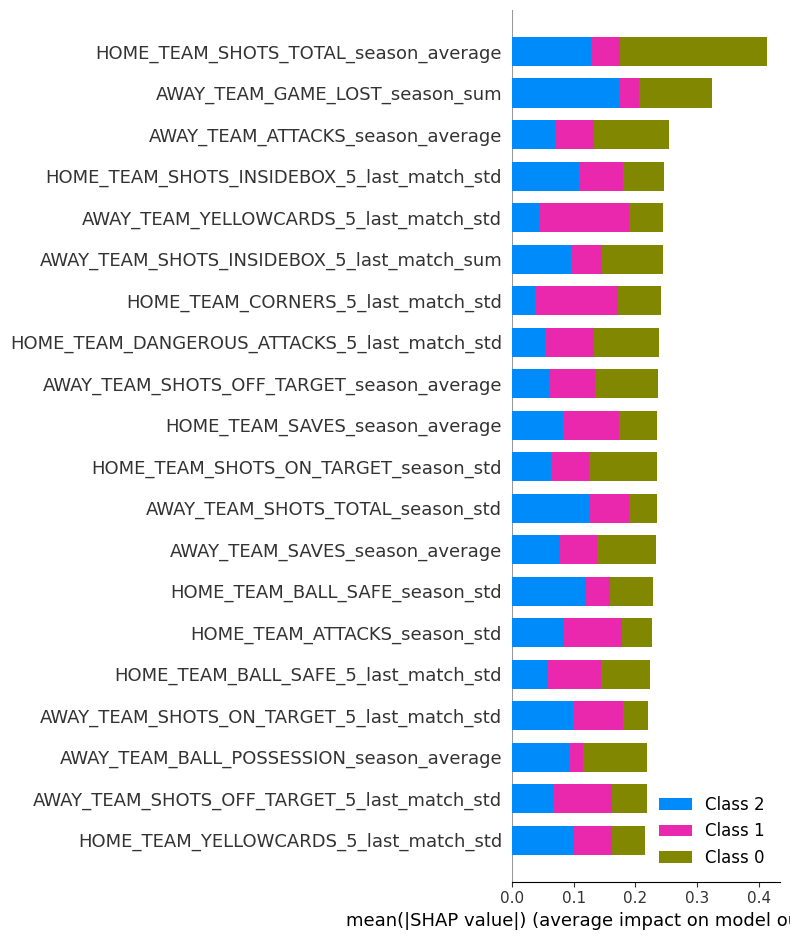

<Figure size 640x480 with 0 Axes>

In [63]:
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Visualiser
shap.summary_plot(shap_values, X_test)
plt.gcf().subplots_adjust(bottom=0.05, left=0.05, right=0.95, top=0.95)

De même ici plus la valeur est haute dans plus elle influence le model.

Le plus impactant semble toujours être le total de tire de l'équipe a domicile (a quelle point elle se créée des ocasions), on notera aussi que le nombre de match perdu par l'équipe exterieur sort du lot. Les autres features semblent-elles sont serré quant a lors importance.

Les résultats de XGBoost et SHAP mettent en lumière des caractéristiques clés influençant les prédictions du modèle, avec des similitudes et des différences notables. Les deux méthodes s'accordent sur l'importance des tirs totaux de l'équipe à domicile, soulignant son rôle crucial dans les prédictions. Cependant, XGBoost se concentre davantage sur des aspects globaux comme les matchs nuls récents et la possession de balle, tandis que SHAP offre une vue plus détaillée, montrant comment chaque caractéristique influence les différentes classes de résultats. Ensemble, ces méthodes fournissent une compréhension complète, XGBoost donnant une vue d'ensemble et SHAP une analyse granulaire des impacts spécifiques.

## LOFO
Leave One Feature Out: on retire une feature pour voir l'impact sur la précision

In [ ]:
from sklearn.metrics import accuracy_score

def evaluate_model_without_feature(X_train, X_test, y_train, y_test, feature_to_exclude):
    # Exclure la caractéristique
    X_train_reduced = X_train.drop(columns=[feature_to_exclude])
    X_test_reduced = X_test.drop(columns=[feature_to_exclude])

    # Entraîner le modèle
    model = xgb.XGBClassifier(random_state=42)
    model.fit(X_train_reduced, y_train)

    # Prédire et évaluer
    y_pred = model.predict(X_test_reduced)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Liste des caractéristiques
features = ['HOME_TEAM_SHOTS_TOTAL_season_average',
 'HOME_TEAM_GAME_DRAW_5_last_match_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_average',
 'AWAY_TEAM_BALL_POSSESSION_season_average',
 'HOME_TEAM_GAME_WON_season_sum',
 'AWAY_TEAM_GAME_WON_season_sum',
 'HOME_TEAM_GAME_WON_season_average',
 'HOME_TEAM_BALL_POSSESSION_season_average',
 'AWAY_TEAM_GAME_WON_season_average',
 'HOME_TEAM_SUCCESSFUL_PASSES_season_average',
 'HOME_TEAM_SHOTS_ON_TARGET_season_sum',
 'AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_sum',
 'AWAY_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SAVES_5_last_match_sum',
 'HOME_TEAM_DANGEROUS_ATTACKS_season_sum',
 'AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average',
 'AWAY_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_GAME_LOST_season_average',
 'HOME_TEAM_SHOTS_INSIDEBOX_season_average',
 'HOME_TEAM_CORNERS_5_last_match_sum']

# Évaluer le modèle sans chaque caractéristique
accuracies = {}
for feature in features:
    accuracy = evaluate_model_without_feature(X_train, X_test, y_train, y_test, feature)
    accuracies[feature] = accuracy

# Accuracy de base
base_accuracy = accuracy_score(y_test, model.predict(X_test))

# Afficher les résultats
accuracies_df = pd.DataFrame(list(accuracies.items()), columns=['Feature', 'Accuracy'])
accuracies_df = accuracies_df.sort_values(by='Accuracy', ascending=False)
print(accuracies_df)

                                              Feature  Accuracy
10               HOME_TEAM_SHOTS_ON_TARGET_season_sum  0.276717
17                 HOME_TEAM_GAME_LOST_season_average  0.273872
11         AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_sum  0.271841
8                   AWAY_TEAM_GAME_WON_season_average  0.271028
4                       HOME_TEAM_GAME_WON_season_sum  0.269809
16           AWAY_TEAM_SHOTS_INSIDEBOX_season_average  0.268184
13                   HOME_TEAM_SAVES_5_last_match_sum  0.266152
5                       AWAY_TEAM_GAME_WON_season_sum  0.266152
7            HOME_TEAM_BALL_POSSESSION_season_average  0.265746
2      AWAY_TEAM_SHOTS_INSIDEBOX_5_last_match_average  0.264933
9          HOME_TEAM_SUCCESSFUL_PASSES_season_average  0.264527
1            HOME_TEAM_GAME_DRAW_5_last_match_average  0.264527
15  AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_...  0.264527
19                 HOME_TEAM_CORNERS_5_last_match_sum  0.263308
14             HOME_TEAM_DANGEROUS_ATTAC